# **Toronto Crime Predictions**

In [44]:
# Dependencies
import requests
import json
import pprint #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.cluster import DBSCAN #

---

## **Retrieve Data from API**

In [2]:
# Initialize the base URL and the initial parameters
base_url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Major_Crime_Indicators_Open_Data/FeatureServer/0/query'
params = {
    'where': 'OCC_YEAR<=2024 AND OCC_YEAR>=2021',
    'outFields': '*',
    'resultRecordCount': 2000,
    'resultOffset': 0,
    'f': 'geojson'
}
# Create an empty list to store all the results
crime_json_array = []
# Start the loop to paginate through the results
while True:
    response = requests.get(base_url, params=params).json()
    # Add the current batch of features to the list
    crime_json_array.extend(response['features'])
    # Check if 'exceededTransferLimit' is True, which means there are more records
    if 'properties' in response and response['properties'].get('exceededTransferLimit', False):
        # Increment the offset to get the next batch of records
        params['resultOffset'] += params['resultRecordCount']
    else:
        # Exit the loop if there are no more records to retrieve
        break

In [3]:
# View the raw JSON data
crime_json_array

[{'type': 'Feature',
  'id': 246675,
  'geometry': {'type': 'Point',
   'coordinates': [-79.425761926, 43.6817690130001]},
  'properties': {'OBJECTID': 246675,
   'EVENT_UNIQUE_ID': 'GO-20213605',
   'REPORT_DATE': 1609477200000,
   'OCC_DATE': 1609477200000,
   'REPORT_YEAR': 2021,
   'REPORT_MONTH': 'January',
   'REPORT_DAY': 1,
   'REPORT_DOY': 1,
   'REPORT_DOW': 'Friday    ',
   'REPORT_HOUR': 16,
   'OCC_YEAR': 2021,
   'OCC_MONTH': 'January',
   'OCC_DAY': 1,
   'OCC_DOY': 1,
   'OCC_DOW': 'Friday    ',
   'OCC_HOUR': 16,
   'DIVISION': 'D13',
   'LOCATION_TYPE': 'Parking Lots (Apt., Commercial Or Non-Commercial)',
   'PREMISES_TYPE': 'Outside',
   'UCR_CODE': 2135,
   'UCR_EXT': 210,
   'OFFENCE': 'Theft Of Motor Vehicle',
   'MCI_CATEGORY': 'Auto Theft',
   'HOOD_158': '094',
   'NEIGHBOURHOOD_158': 'Wychwood (94)',
   'HOOD_140': '094',
   'NEIGHBOURHOOD_140': 'Wychwood (94)',
   'LONG_WGS84': -79.42576192637651,
   'LAT_WGS84': 43.68176901263976}},
 {'type': 'Feature',
  'i

In [4]:
def arrange_crime_json_array(crime):
    """ Function for filtering out the API query metdata, and getting a JSON list of just the crime data"""
    crime_case = crime['properties']
    return crime_case

In [5]:
# Using a list comprehension to apply the function for each entry in the intial crime JSON array.
crime_json_list = [crime['properties'] for crime in crime_json_array]
crime_json_list

[{'OBJECTID': 246675,
  'EVENT_UNIQUE_ID': 'GO-20213605',
  'REPORT_DATE': 1609477200000,
  'OCC_DATE': 1609477200000,
  'REPORT_YEAR': 2021,
  'REPORT_MONTH': 'January',
  'REPORT_DAY': 1,
  'REPORT_DOY': 1,
  'REPORT_DOW': 'Friday    ',
  'REPORT_HOUR': 16,
  'OCC_YEAR': 2021,
  'OCC_MONTH': 'January',
  'OCC_DAY': 1,
  'OCC_DOY': 1,
  'OCC_DOW': 'Friday    ',
  'OCC_HOUR': 16,
  'DIVISION': 'D13',
  'LOCATION_TYPE': 'Parking Lots (Apt., Commercial Or Non-Commercial)',
  'PREMISES_TYPE': 'Outside',
  'UCR_CODE': 2135,
  'UCR_EXT': 210,
  'OFFENCE': 'Theft Of Motor Vehicle',
  'MCI_CATEGORY': 'Auto Theft',
  'HOOD_158': '094',
  'NEIGHBOURHOOD_158': 'Wychwood (94)',
  'HOOD_140': '094',
  'NEIGHBOURHOOD_140': 'Wychwood (94)',
  'LONG_WGS84': -79.42576192637651,
  'LAT_WGS84': 43.68176901263976},
 {'OBJECTID': 246676,
  'EVENT_UNIQUE_ID': 'GO-20213400',
  'REPORT_DATE': 1609477200000,
  'OCC_DATE': 1609477200000,
  'REPORT_YEAR': 2021,
  'REPORT_MONTH': 'January',
  'REPORT_DAY': 1,
  

In [6]:
# Convert the JSON array into a Dataframe
crime_data_original = pd.DataFrame(crime_json_list)
crime_data_original

,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,UCR_CODE,UCR_EXT,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,246675,GO-20213605,1609477200000,1609477200000,2021,January,1,1,Friday,16,...,2135,210,Theft Of Motor Vehicle,Auto Theft,094,Wychwood (94),094,Wychwood (94),-79.425762,43.681769
1,246676,GO-20213400,1609477200000,1609477200000,2021,January,1,1,Friday,16,...,2135,210,Theft Of Motor Vehicle,Auto Theft,NSA,NSA,NSA,NSA,0.000000,0.000000
2,246677,GO-20211123,1609477200000,1609477200000,2021,January,1,1,Friday,7,...,2135,210,Theft Of Motor Vehicle,Auto Theft,031,Yorkdale-Glen Park (31),031,Yorkdale-Glen Park (31),-79.460110,43.721013
3,246678,GO-2021445,1609477200000,1609477200000,2021,January,1,1,Friday,1,...,2135,210,Theft Of Motor Vehicle,Auto Theft,151,Yonge-Doris (151),051,Willowdale East (51),-79.415293,43.778743
4,246679,GO-20213400,1609477200000,1609477200000,2021,January,1,1,Friday,16,...,2135,210,Theft Of Motor Vehicle,Auto Theft,NSA,NSA,NSA,NSA,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147546,396731,GO-20241427047,1719723600000,1719637200000,2024,June,30,182,Sunday,16,...,1430,100,Assault,Assault,071,Cabbagetown-South St.James Town (71),071,Cabbagetown-South St.James Town (71),-79.373043,43.663195
147547,396732,GO-20241427869,1719723600000,1719723600000,2024,June,30,182,Sunday,18,...,2133,200,Theft Over - Shoplifting,Theft Over,027,York University Heights (27),027,York University Heights (27),-79.464942,43.759469
147548,396733,GO-20241423116,1719723600000,1719637200000,2024,June,30,182,Sunday,2,...,1450,120,Discharge Firearm With Intent,Assault,144,Morningside Heights (144),131,Rouge (131),-79.248477,43.837237
147549,396734,GO-20241426669,1719723600000,1718859600000,2024,June,30,182,Sunday,15,...,2132,200,Theft From Motor Vehicle Over,Theft Over,160,Mimico-Queensway (160),017,Mimico (includes Humber Bay Shores) (17),-79.521053,43.616490




---



## **Preprocess the Data**

In [7]:
# Get all the column names in crime_data_original
crime_data_original.columns

Index(['OBJECTID', 'EVENT_UNIQUE_ID', 'REPORT_DATE', 'OCC_DATE', 'REPORT_YEAR',
       'REPORT_MONTH', 'REPORT_DAY', 'REPORT_DOY', 'REPORT_DOW', 'REPORT_HOUR',
       'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_DOY', 'OCC_DOW', 'OCC_HOUR',
       'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'UCR_CODE', 'UCR_EXT',
       'OFFENCE', 'MCI_CATEGORY', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140',
       'NEIGHBOURHOOD_140', 'LONG_WGS84', 'LAT_WGS84'],
      dtype='object')

In [8]:
# Change the value of 'NSA' in the HOOD_158 column to 0 and then convert the column values to integers
crime_data_original['HOOD_158'] = crime_data_original['HOOD_158'].replace('NSA', 0)
crime_data_original['HOOD_158'] = crime_data_original['HOOD_158'].astype(int)
crime_data_original

,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,UCR_CODE,UCR_EXT,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,246675,GO-20213605,1609477200000,1609477200000,2021,January,1,1,Friday,16,...,2135,210,Theft Of Motor Vehicle,Auto Theft,94,Wychwood (94),094,Wychwood (94),-79.425762,43.681769
1,246676,GO-20213400,1609477200000,1609477200000,2021,January,1,1,Friday,16,...,2135,210,Theft Of Motor Vehicle,Auto Theft,0,NSA,NSA,NSA,0.000000,0.000000
2,246677,GO-20211123,1609477200000,1609477200000,2021,January,1,1,Friday,7,...,2135,210,Theft Of Motor Vehicle,Auto Theft,31,Yorkdale-Glen Park (31),031,Yorkdale-Glen Park (31),-79.460110,43.721013
3,246678,GO-2021445,1609477200000,1609477200000,2021,January,1,1,Friday,1,...,2135,210,Theft Of Motor Vehicle,Auto Theft,151,Yonge-Doris (151),051,Willowdale East (51),-79.415293,43.778743
4,246679,GO-20213400,1609477200000,1609477200000,2021,January,1,1,Friday,16,...,2135,210,Theft Of Motor Vehicle,Auto Theft,0,NSA,NSA,NSA,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147546,396731,GO-20241427047,1719723600000,1719637200000,2024,June,30,182,Sunday,16,...,1430,100,Assault,Assault,71,Cabbagetown-South St.James Town (71),071,Cabbagetown-South St.James Town (71),-79.373043,43.663195
147547,396732,GO-20241427869,1719723600000,1719723600000,2024,June,30,182,Sunday,18,...,2133,200,Theft Over - Shoplifting,Theft Over,27,York University Heights (27),027,York University Heights (27),-79.464942,43.759469
147548,396733,GO-20241423116,1719723600000,1719637200000,2024,June,30,182,Sunday,2,...,1450,120,Discharge Firearm With Intent,Assault,144,Morningside Heights (144),131,Rouge (131),-79.248477,43.837237
147549,396734,GO-20241426669,1719723600000,1718859600000,2024,June,30,182,Sunday,15,...,2132,200,Theft From Motor Vehicle Over,Theft Over,160,Mimico-Queensway (160),017,Mimico (includes Humber Bay Shores) (17),-79.521053,43.616490


In [9]:
crime_data_original['OCC_MONTH']

0         January
1         January
2         January
3         January
4         January
           ...   
147546       June
147547       June
147548       June
147549       June
147550       June
Name: OCC_MONTH, Length: 147551, dtype: object

In [10]:
# prompt: Convert the crime_data_original column OCC_MONTH's month names to integer form

month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

crime_data_original['OCC_MONTH'] = crime_data_original['OCC_MONTH'].map(month_mapping)
crime_data_original['OCC_MONTH']


0         1
1         1
2         1
3         1
4         1
         ..
147546    6
147547    6
147548    6
147549    6
147550    6
Name: OCC_MONTH, Length: 147551, dtype: int64

In [11]:
# Collect only the necessary columns for the analysis
crime_pd = crime_data_original[['EVENT_UNIQUE_ID', 'NEIGHBOURHOOD_158', 'HOOD_158', 'LAT_WGS84', 'LONG_WGS84', 'PREMISES_TYPE', 'OCC_DATE', 'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_HOUR', 'MCI_CATEGORY']]
crime_pd


,EVENT_UNIQUE_ID,NEIGHBOURHOOD_158,HOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,MCI_CATEGORY
0,GO-20213605,Wychwood (94),94,43.681769,-79.425762,Outside,1609477200000,2021,1,1,16,Auto Theft
1,GO-20213400,NSA,0,0.000000,0.000000,Commercial,1609477200000,2021,1,1,4,Auto Theft
2,GO-20211123,Yorkdale-Glen Park (31),31,43.721013,-79.460110,Other,1609477200000,2021,1,1,4,Auto Theft
3,GO-2021445,Yonge-Doris (151),151,43.778743,-79.415293,Other,1609477200000,2021,1,1,1,Auto Theft
4,GO-20213400,NSA,0,0.000000,0.000000,Commercial,1609477200000,2021,1,1,4,Auto Theft
...,...,...,...,...,...,...,...,...,...,...,...,...
147546,GO-20241427047,Cabbagetown-South St.James Town (71),71,43.663195,-79.373043,Apartment,1719637200000,2024,6,29,23,Assault
147547,GO-20241427869,York University Heights (27),27,43.759469,-79.464942,Commercial,1719723600000,2024,6,30,18,Theft Over
147548,GO-20241423116,Morningside Heights (144),144,43.837237,-79.248477,Outside,1719637200000,2024,6,29,21,Assault
147549,GO-20241426669,Mimico-Queensway (160),160,43.616490,-79.521053,Outside,1718859600000,2024,6,20,13,Theft Over


In [12]:
# Encode the MCI_CATEGORY column using get_dummies
crime_category_encoded = pd.get_dummies(crime_pd['MCI_CATEGORY']).astype(int)
crime_category_encoded


,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
147546,1,0,0,0,0
147547,0,0,0,0,1
147548,1,0,0,0,0
147549,0,0,0,0,1


In [13]:
# Add the encoded columns back into the datframe
crime_pd = pd.concat([crime_pd, crime_category_encoded], axis=1)
crime_pd_encoded = crime_pd.drop(['MCI_CATEGORY'], axis=1) # Drop the original MCI_CATEGORY column
crime_pd_encoded

,EVENT_UNIQUE_ID,NEIGHBOURHOOD_158,HOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,GO-20213605,Wychwood (94),94,43.681769,-79.425762,Outside,1609477200000,2021,1,1,16,0,1,0,0,0
1,GO-20213400,NSA,0,0.000000,0.000000,Commercial,1609477200000,2021,1,1,4,0,1,0,0,0
2,GO-20211123,Yorkdale-Glen Park (31),31,43.721013,-79.460110,Other,1609477200000,2021,1,1,4,0,1,0,0,0
3,GO-2021445,Yonge-Doris (151),151,43.778743,-79.415293,Other,1609477200000,2021,1,1,1,0,1,0,0,0
4,GO-20213400,NSA,0,0.000000,0.000000,Commercial,1609477200000,2021,1,1,4,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147546,GO-20241427047,Cabbagetown-South St.James Town (71),71,43.663195,-79.373043,Apartment,1719637200000,2024,6,29,23,1,0,0,0,0
147547,GO-20241427869,York University Heights (27),27,43.759469,-79.464942,Commercial,1719723600000,2024,6,30,18,0,0,0,0,1
147548,GO-20241423116,Morningside Heights (144),144,43.837237,-79.248477,Outside,1719637200000,2024,6,29,21,1,0,0,0,0
147549,GO-20241426669,Mimico-Queensway (160),160,43.616490,-79.521053,Outside,1718859600000,2024,6,20,13,0,0,0,0,1


In [14]:
# Group the values by EVENT_UNIQUE_ID and get the first value for all the columns, except for Assault, Auto Theft, Break and Enter, Robbery, Theft Over
crime_first_group = crime_pd_encoded.groupby('EVENT_UNIQUE_ID')[["NEIGHBOURHOOD_158", "HOOD_158", "LAT_WGS84", "LONG_WGS84", "PREMISES_TYPE", "OCC_DATE", "OCC_YEAR", "OCC_MONTH", "OCC_DAY", "OCC_HOUR"]].first()
crime_first_group

,NEIGHBOURHOOD_158,HOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR
EVENT_UNIQUE_ID,,,,,,,,,,
GO-20211000033,West Queen West (162),162,43.646286,-79.408568,Commercial,1622264400000,2021,5,29,21
GO-2021100004,Morningside Heights (144),144,43.807252,-79.162903,Outside,1610773200000,2021,1,16,17
GO-20211000054,Moss Park (73),73,43.657067,-79.374531,Apartment,1622264400000,2021,5,29,22
GO-20211000193,Fort York-Liberty Village (163),163,43.636618,-79.399704,Apartment,1622264400000,2021,5,29,23
GO-20211000248,Eglinton East (138),138,43.737099,-79.246230,Outside,1622264400000,2021,5,29,21
...,...,...,...,...,...,...,...,...,...,...
GO-20249997,Junction-Wallace Emerson (171),171,43.668917,-79.442637,Outside,1704085200000,2024,1,1,18
GO-202499972,Edenbridge-Humber Valley (9),9,43.672705,-79.522472,House,1705208400000,2024,1,14,3
GO-2024999786,Flemingdon Park (44),44,43.718727,-79.334948,Apartment,1714539600000,2024,5,1,0


In [15]:
# Group the MCI_CATEGORY values by EVENT_UNIQUE_ID and get the maximum value.
crime_max_group = crime_pd_encoded.groupby('EVENT_UNIQUE_ID')[["Assault", "Auto Theft", "Break and Enter", "Robbery", "Theft Over"]].max()
crime_max_group

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
EVENT_UNIQUE_ID,,,,,
GO-20211000033,0,0,1,0,0
GO-2021100004,0,1,0,0,0
GO-20211000054,1,0,0,0,0
GO-20211000193,1,0,0,0,0
GO-20211000248,1,0,0,0,0
...,...,...,...,...,...
GO-20249997,0,1,0,0,0
GO-202499972,0,1,0,0,0
GO-2024999786,1,0,0,0,0


In [16]:
# Concatenate the two groups together into one Dataframe and reset the index so that EVENT_UNIQUE_ID is not the index.
crime_groups_joined = pd.concat([crime_first_group, crime_max_group], axis=1)
crime_groups_joined = crime_groups_joined.reset_index()
crime_groups_joined

,EVENT_UNIQUE_ID,NEIGHBOURHOOD_158,HOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,GO-20211000033,West Queen West (162),162,43.646286,-79.408568,Commercial,1622264400000,2021,5,29,21,0,0,1,0,0
1,GO-2021100004,Morningside Heights (144),144,43.807252,-79.162903,Outside,1610773200000,2021,1,16,17,0,1,0,0,0
2,GO-20211000054,Moss Park (73),73,43.657067,-79.374531,Apartment,1622264400000,2021,5,29,22,1,0,0,0,0
3,GO-20211000193,Fort York-Liberty Village (163),163,43.636618,-79.399704,Apartment,1622264400000,2021,5,29,23,1,0,0,0,0
4,GO-20211000248,Eglinton East (138),138,43.737099,-79.246230,Outside,1622264400000,2021,5,29,21,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129212,GO-20249997,Junction-Wallace Emerson (171),171,43.668917,-79.442637,Outside,1704085200000,2024,1,1,18,0,1,0,0,0
129213,GO-202499972,Edenbridge-Humber Valley (9),9,43.672705,-79.522472,House,1705208400000,2024,1,14,3,0,1,0,0,0
129214,GO-2024999786,Flemingdon Park (44),44,43.718727,-79.334948,Apartment,1714539600000,2024,5,1,0,1,0,0,0,0
129215,GO-2024999795,Oakridge (121),121,43.691225,-79.288346,Commercial,1715230800000,2024,5,9,13,1,0,0,0,0


---

## **Creating the Model**

## Testing Different Models

In [17]:
# Create a Total_Count column in the crime_groups_joined dataframe
crime_groups_joined['Total_Count'] = crime_groups_joined.iloc[:, 11:].sum(axis=1)
crime_groups_joined

,EVENT_UNIQUE_ID,NEIGHBOURHOOD_158,HOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Total_Count
0,GO-20211000033,West Queen West (162),162,43.646286,-79.408568,Commercial,1622264400000,2021,5,29,21,0,0,1,0,0,1
1,GO-2021100004,Morningside Heights (144),144,43.807252,-79.162903,Outside,1610773200000,2021,1,16,17,0,1,0,0,0,1
2,GO-20211000054,Moss Park (73),73,43.657067,-79.374531,Apartment,1622264400000,2021,5,29,22,1,0,0,0,0,1
3,GO-20211000193,Fort York-Liberty Village (163),163,43.636618,-79.399704,Apartment,1622264400000,2021,5,29,23,1,0,0,0,0,1
4,GO-20211000248,Eglinton East (138),138,43.737099,-79.246230,Outside,1622264400000,2021,5,29,21,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129212,GO-20249997,Junction-Wallace Emerson (171),171,43.668917,-79.442637,Outside,1704085200000,2024,1,1,18,0,1,0,0,0,1
129213,GO-202499972,Edenbridge-Humber Valley (9),9,43.672705,-79.522472,House,1705208400000,2024,1,14,3,0,1,0,0,0,1
129214,GO-2024999786,Flemingdon Park (44),44,43.718727,-79.334948,Apartment,1714539600000,2024,5,1,0,1,0,0,0,0,1
129215,GO-2024999795,Oakridge (121),121,43.691225,-79.288346,Commercial,1715230800000,2024,5,9,13,1,0,0,0,0,1


In [18]:
# Group the crime_groups_joined dataframe by neighbourhood, occ_year, occ_month,
# get the count of the rows aggregated to each group, and place those values in the Total_Count column.
crime_totals_by_month_year_hood = crime_groups_joined.groupby(['HOOD_158', 'OCC_YEAR', 'OCC_MONTH'])[['Total_Count']].count()
crime_totals_by_month_year_hood = crime_totals_by_month_year_hood.reset_index()
crime_totals_by_month_year_hood

,HOOD_158,OCC_YEAR,OCC_MONTH,Total_Count
0,0,2021,1,44
1,0,2021,2,34
2,0,2021,3,45
3,0,2021,4,26
4,0,2021,5,37
...,...,...,...,...
6672,174,2024,2,15
6673,174,2024,3,7
6674,174,2024,4,17
6675,174,2024,5,12


In [19]:
# Group the crime_groups_joined dataframe by neighbourhood, occ_year, occ_month and get the sum of assaults, auto theft, break and enter, robbery, and theft over.
crime_types_by_month_year_hood = crime_groups_joined.groupby(['HOOD_158', 'OCC_YEAR', 'OCC_MONTH'])[["Assault", "Auto Theft", "Break and Enter", "Robbery", "Theft Over"]].sum()
crime_types_by_month_year_hood = crime_types_by_month_year_hood.reset_index()
# Concatenate crime_totals_by_month_year_hood and crime_types_by_month_year_hood intot a single dataframe
crime_by_month_year_hood = pd.concat([crime_types_by_month_year_hood, crime_totals_by_month_year_hood['Total_Count']], axis=1)
crime_by_month_year_hood.sort_values(by=['Total_Count'])

,HOOD_158,OCC_YEAR,OCC_MONTH,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Total_Count
1895,49,2021,6,1,0,1,0,0,1
2229,58,2021,4,0,0,1,0,0,1
1909,49,2022,8,0,1,0,0,0,1
5208,140,2021,2,1,0,0,0,0,1
1890,49,2021,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
77,1,2023,12,30,45,28,4,13,118
68,1,2023,3,18,83,12,3,3,119
65,1,2022,12,24,67,15,4,10,120
71,1,2023,6,24,77,22,4,5,131


In [20]:
# Show all the rows where HOOD_158 has a value of 0
crime_by_month_year_hood.loc[crime_by_month_year_hood['HOOD_158'] == 0, :]

,HOOD_158,OCC_YEAR,OCC_MONTH,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Total_Count
0,0,2021,1,23,2,10,9,1,44
1,0,2021,2,24,1,8,1,0,34
2,0,2021,3,27,7,5,5,3,45
3,0,2021,4,16,1,3,3,3,26
4,0,2021,5,30,3,3,1,1,37
5,0,2021,6,22,3,3,2,3,32
6,0,2021,7,29,2,3,6,2,42
7,0,2021,8,48,6,2,7,3,66
8,0,2021,9,27,8,6,3,3,47
9,0,2021,10,39,9,15,2,2,65


In [21]:
# Filter out the rows where the column HOOD_158 has a value of 0
crime_by_month_year_hood = crime_by_month_year_hood.loc[crime_by_month_year_hood['HOOD_158'] != 0, :]
crime_by_month_year_hood = crime_by_month_year_hood.reset_index(drop=True)
crime_by_month_year_hood

,HOOD_158,OCC_YEAR,OCC_MONTH,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Total_Count
0,1,2021,1,18,35,7,1,3,62
1,1,2021,2,17,17,5,1,3,43
2,1,2021,3,15,20,8,6,6,54
3,1,2021,4,11,31,4,2,4,52
4,1,2021,5,18,26,9,5,4,62
...,...,...,...,...,...,...,...,...,...
6630,174,2024,2,9,0,5,1,1,15
6631,174,2024,3,6,1,0,0,0,7
6632,174,2024,4,12,2,2,0,1,17
6633,174,2024,5,8,1,2,0,1,12


In [22]:
# Have the training data be all the data in crime_by_month_year_hood for the years 2021 to 2023
train_data = crime_by_month_year_hood.loc[crime_by_month_year_hood['OCC_YEAR'].isin([2021, 2022, 2023]), :]

# Have the testing data be all the data in crime_by_month_year_hood for the year 2024
test_data = crime_by_month_year_hood.loc[crime_by_month_year_hood['OCC_YEAR'] == 2024, :]

In [23]:
# Split the training data into the features and targets
X_train = train_data[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]  # Features

X_test = test_data[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]  # Features

y_train = train_data[['Total_Count']]  # Target

y_test = test_data[['Total_Count']]  # Target

In [24]:
# Initialize the Random Forest Regressor
r_model = RandomForestRegressor()

# Train the model on the training data
r_model.fit(X_train, y_train)

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [25]:
# Initialize the Histogram-Based Gradient Boosting Regressor and wrap it with MultiOutputRegressor
h_model = MultiOutputRegressor(HistGradientBoostingRegressor())

# Train the model on the training data
h_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor())

In [26]:
# Make predictions on the test set with the Random Forest Regressor
y_r_pred = r_model.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor
y_h_pred = h_model.predict(X_test)

# Print the predicted crime counts for the test set for both models
print("Random Forest Predicted crime counts for (test set):", y_r_pred)
print("Histogram-Based Gradient Boosting Predicted crime counts for (test set):", y_h_pred)

Random Forest Predicted crime counts for (test set): [123.67 113.7  116.53 112.63 112.21 123.19  33.37  32.76  31.56  37.49
  40.38  44.94  13.45   7.65  10.34  15.3   14.9    9.27  19.8   12.75
  14.63  14.15  12.72  10.56  12.8    9.6   11.1   12.48   9.5    9.91
  18.88  18.81  27.71  24.27  27.93  22.59  23.95  21.02  32.81  17.63
  16.85  21.6    7.56   4.8    4.47   7.67   8.13   9.71  16.8   11.03
  10.22  13.05  18.85  20.56  16.88  12.42  13.28  14.52  17.77  18.65
  20.58  14.03  15.46  12.67  14.62  17.1    8.98   6.86   9.24   6.39
   8.92   8.91  11.49   9.95  10.44   9.19  10.3    7.5   14.04  15.03
  14.49  15.05  18.5   18.09  30.83  31.4   31.36  32.78  36.93  32.86
  20.19  12.83  15.72  14.51  19.4   23.26  10.24  10.49  10.28  10.39
  12.57  12.61   8.71   8.01   7.55   7.39  12.27   9.01  26.24  21.73
  29.04  24.98  27.73  34.    23.75  16.08  21.17  25.12  27.27  20.4
  17.84  16.75  15.2   20.06  17.65  19.3   23.43  25.32  25.38  24.29
  27.78  23.15  28.86  27

In [27]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Mean Squared Error: 47.68928860759494
R-squared: 0.7797428888469431
mean absolute error: 5.133544303797469


In [28]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting.
h_mse = mean_squared_error(y_test, y_h_pred)
h_r2 = r2_score(y_test, y_h_pred)
h_mae = mean_absolute_error(y_test, y_h_pred)

print(f"Mean Squared Error: {h_mse}")
print(f"R-squared: {h_r2}")
print(f"mean absolute error: {h_mae}")

Mean Squared Error: 42.3805269624916
R-squared: 0.8042618644469353
mean absolute error: 5.0338833270972545


## Comparison of Actual vlaues and the Predicted values

In [48]:
#  y_test and y_h_pred comparison -Random Forests.
comparison_r_df = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': np.array(y_r_pred).flatten()})
comparison_r_df.head()


,Actual,Predicted
0,110,89.785145
1,101,90.539374
2,79,97.103920
3,93,98.322491
4,104,102.206774


In [49]:

#  y_test and y_h_pred comparison -Histogram-Based Gradient Boosting
comparison_h_df = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': np.array(y_h_pred).flatten()})
comparison_h_df.head()


,Actual,Predicted
0,110,105.099712
1,101,102.681816
2,79,106.270221
3,93,106.270221
4,104,107.321723


In [137]:
# Step 1: Filter for 2024
crime_2024 = crime_by_month_year_hood[crime_by_month_year_hood['OCC_YEAR']== 2024]

# Step 2: Create the comparison_h_df DataFrame
comparison_h_df = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': np.array(y_h_pred).flatten()})

# view the comparison_h_df with OCC_MONTH added
comparison_h_df['OCC_MONTH'] = crime_2024['OCC_MONTH'].values
comparison_h_df['HOOD_158'] = crime_2024['HOOD_158'] .values
comparison_h_df


,Actual,Predicted,OCC_MONTH,HOOD_158
0,110,105.099712,1,1
1,101,102.681816,2,1
2,79,106.270221,3,1
3,93,106.270221,4,1
4,104,107.321723,5,1
...,...,...,...,...
943,15,10.442469,2,174
944,7,13.567322,3,174
945,17,13.567322,4,174
946,12,14.498041,5,174


   OCC_MONTH     Actual  Predicted
0          1  22.265823  20.244786
1          2  20.158228  19.221708
2          3  20.297468  21.507194
3          4  20.259494  21.640763
4          5  21.968354  22.978526
5          6  19.626582  22.984738


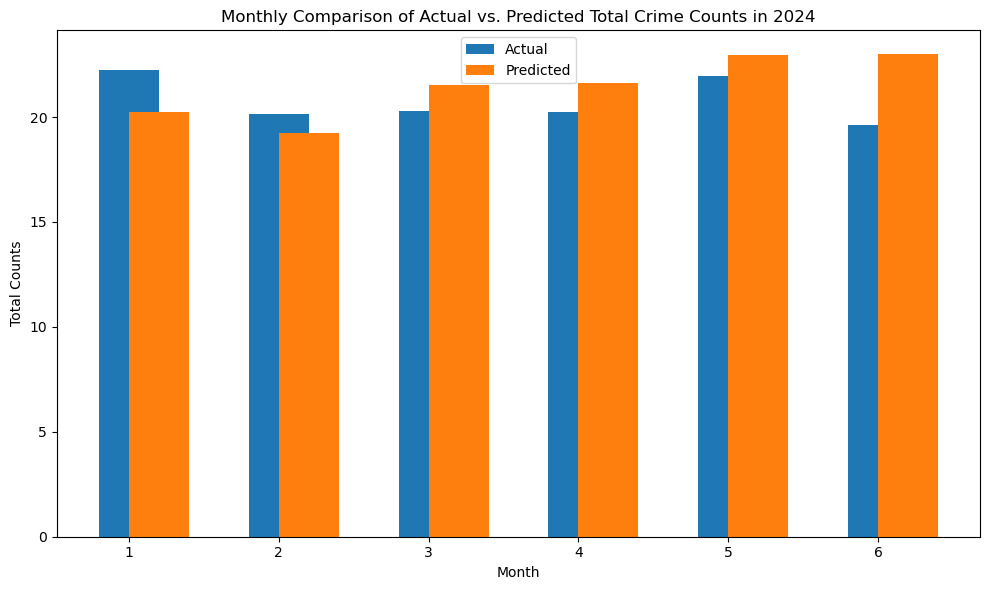

In [81]:

# Group by OCC_MONTH and calculate the sum for Actual_Total and Predicted_Total
monthly_comparison_2024 = comparison_h_df.groupby('OCC_MONTH')[['Actual', 'Predicted']].mean().reset_index()

# Display the grouped DataFrame
print(monthly_comparison_2024)

# Plotting the results

plt.figure(figsize=(10, 6))
plt.bar(monthly_comparison_2024['OCC_MONTH'], monthly_comparison_2024['Actual'], width=0.4, label='Actual', align='center')
plt.bar(monthly_comparison_2024['OCC_MONTH'], monthly_comparison_2024['Predicted'], width=0.4, label='Predicted', align='edge')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Total Counts')
plt.title('Monthly Comparison of Actual vs. Predicted Total Crime Counts in 2024')
plt.xticks(monthly_comparison_2024['OCC_MONTH'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


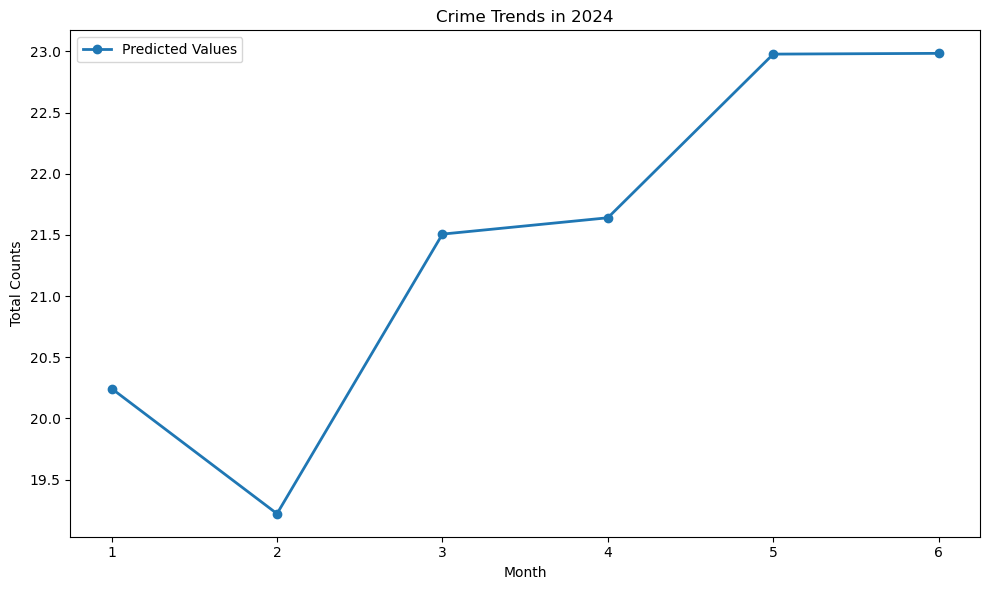

In [139]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(monthly_comparison_2024['OCC_MONTH'], monthly_comparison_2024['Predicted'], linewidth=2, label='Predicted Values', marker='o')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Total Counts')
plt.title('Crime Trends in 2024')
plt.xticks(monthly_comparison_2024['OCC_MONTH'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Predicting Visualizations

In [127]:
# Create a copy of the original DataFrame
crime_by_month_year_hood_copy = crime_by_month_year_hood.copy()

# Filter out rows where OCC_YEAR is 2024
crime_2025_2027 = crime_by_month_year_hood_copy[crime_by_month_year_hood_copy['OCC_YEAR'] != 2024]

# Display the filtered DataFrame
crime_2025_2027


,HOOD_158,OCC_YEAR,OCC_MONTH,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Total_Count
0,1,2021,1,18,35,7,1,3,62
1,1,2021,2,17,17,5,1,3,43
2,1,2021,3,15,20,8,6,6,54
3,1,2021,4,11,31,4,2,4,52
4,1,2021,5,18,26,9,5,4,62
...,...,...,...,...,...,...,...,...,...
6624,174,2023,8,2,3,2,0,0,7
6625,174,2023,9,4,3,3,0,0,10
6626,174,2023,10,8,1,5,0,0,14
6627,174,2023,11,4,1,9,0,1,15


In [128]:
# Replace 2021 with 2025, 2022 with 2026, and 2023 with 2027 in OCC_YEAR
crime_2025_2027['OCC_YEAR'] = crime_2025_2027['OCC_YEAR'].replace({2021: 2025, 2022: 2026, 2023: 2027})

# Drop the columns Assault	Auto Theft	Break and Enter	Robbery	Theft Over	Total_Count
crime_2025_2027 = crime_2025_2027.drop(columns=[
'Assault','Auto Theft','Break and Enter',	'Robbery','Theft Over','Total_Count'])
# Display the updated DataFrame 
crime_2025_2027


/var/folders/wz/kwn_hsrs7cx5m5c64kzwf_lm0000gn/T/ipykernel_46750/2853726070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_2025_2027['OCC_YEAR'] = crime_2025_2027['OCC_YEAR'].replace({2021: 2025, 2022: 2026, 2023: 2027})


,HOOD_158,OCC_YEAR,OCC_MONTH
0,1,2025,1
1,1,2025,2
2,1,2025,3
3,1,2025,4
4,1,2025,5
...,...,...,...
6624,174,2027,8
6625,174,2027,9
6626,174,2027,10
6627,174,2027,11


In [129]:
# Prepare features for prediction
X_crime_2025_2027 = crime_2025_2027[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]

# Use the model to predict future values based on the crime_2025_2027 data
predicted_counts = h_model.predict(X_crime_2025_2027)

# Add predictions to the crime_2025_2027 DataFrame
crime_2025_2027['Predicted_Total_Count'] = predicted_counts

# Display the updated DataFrame with predictions
print("Crime Data with Predictions for 2025-2027:")
crime_2025_2027

Crime Data with Predictions for 2025-2027:


,HOOD_158,OCC_YEAR,OCC_MONTH,Predicted_Total_Count
0,1,2025,1,108.438725
1,1,2025,2,105.831068
2,1,2025,3,107.923722
3,1,2025,4,107.923722
4,1,2025,5,109.462838
...,...,...,...,...
6624,174,2027,8,13.215878
6625,174,2027,9,13.286270
6626,174,2027,10,13.976201
6627,174,2027,11,14.396909


In [173]:
crime_2025_2027_by_month = crime_2025_2027.groupby('OCC_YEAR')['Predicted_Total_Count'].sum()
crime_2025_2027_by_month

OCC_YEAR
2025    42179.984799
2026    42179.984799
2027    42170.155824
Name: Predicted_Total_Count, dtype: float64

In [174]:
crime_2025_2027_by_month.shape

(3,)

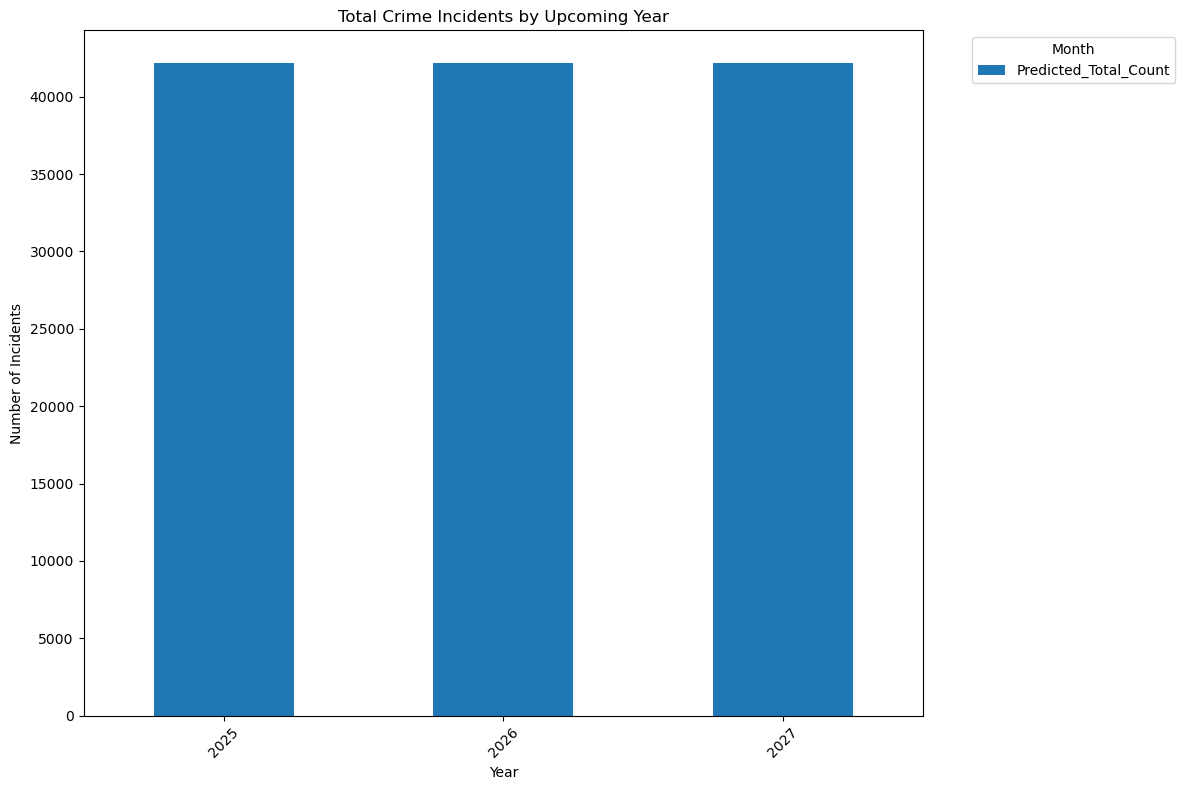

In [175]:
# Plotting the bar chart
crime_2025_2027_by_month.plot(kind='bar', figsize=(12, 8))

plt.title('Total Crime Incidents by Upcoming Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
plt.tight_layout()
plt.show()

In [155]:
# Group the data by year and month and get the mean of Predicted_Total_Count
crime_by_future_year_month = crime_2025_2027.groupby(['OCC_YEAR', 'OCC_MONTH'])['Predicted_Total_Count'].mean().reset_index()
crime_by_future_year_month.head()

,OCC_YEAR,OCC_MONTH,Predicted_Total_Count
0,2025,1,20.152968
1,2025,2,19.074294
2,2025,3,21.345832
3,2025,4,21.520023
4,2025,5,23.588158


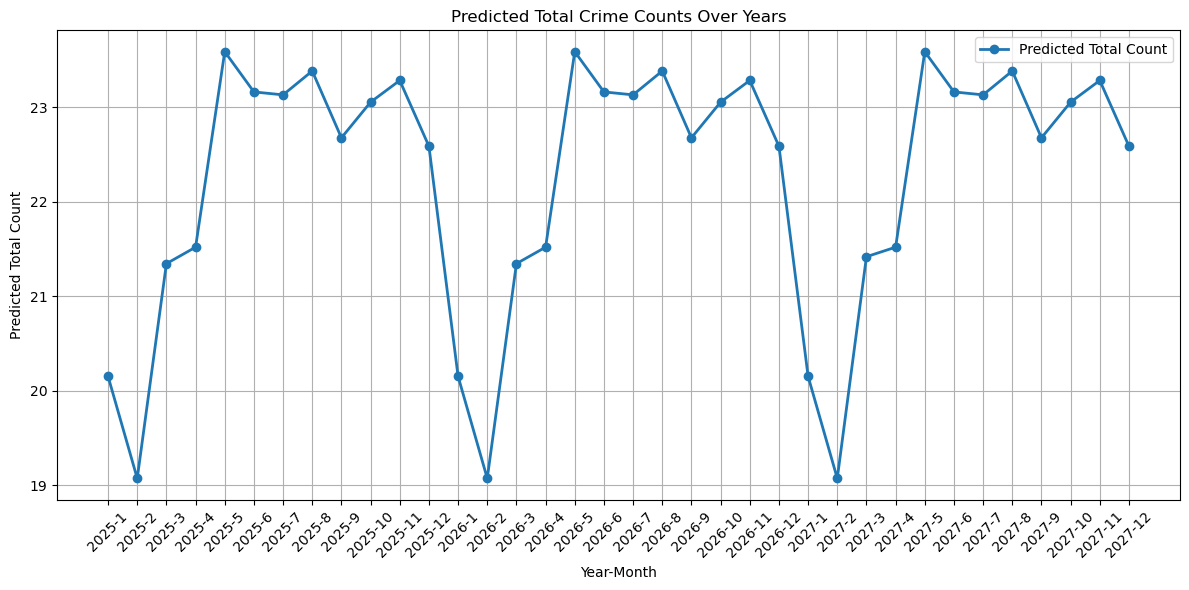

In [163]:
# Create a combined month-year column for plotting
crime_by_future_year_month['Year_Month'] = crime_by_future_year_month['OCC_YEAR'].astype(str) + '-' + crime_by_future_year_month['OCC_MONTH'].astype(str)

# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_by_future_year_month['Year_Month'], 
         crime_by_future_year_month['Predicted_Total_Count'], 
         linewidth=2, marker='o', label='Predicted Total Count')

# Add labels, title, and legend
plt.xlabel('Year-Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Crime Counts Over Years')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [166]:
# Step 1: Filter for 2025,2026 and 2027
crime_2025 = crime_by_future_year_month[crime_by_future_year_month['OCC_YEAR']== 2025]
crime_2026 = crime_by_future_year_month[crime_by_future_year_month['OCC_YEAR']== 2026]
crime_2027 = crime_by_future_year_month[crime_by_future_year_month['OCC_YEAR']== 2027]



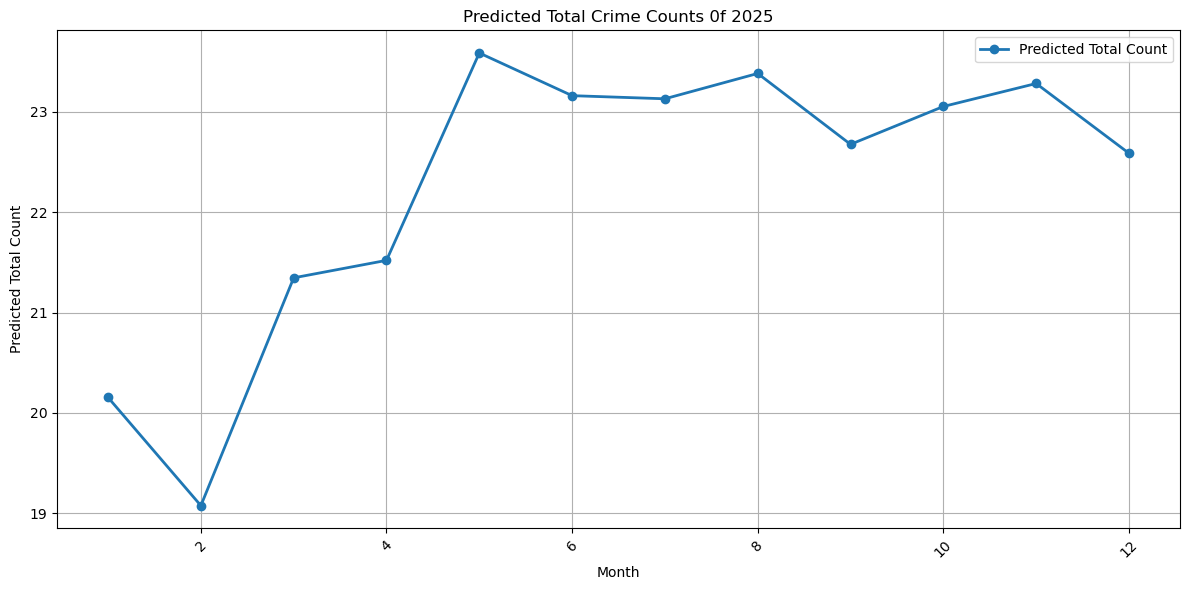

In [165]:
# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2025['OCC_MONTH'], 
         crime_2025['Predicted_Total_Count'], 
         linewidth=2, marker='o', label='Predicted Total Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Crime Counts 0f 2025')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

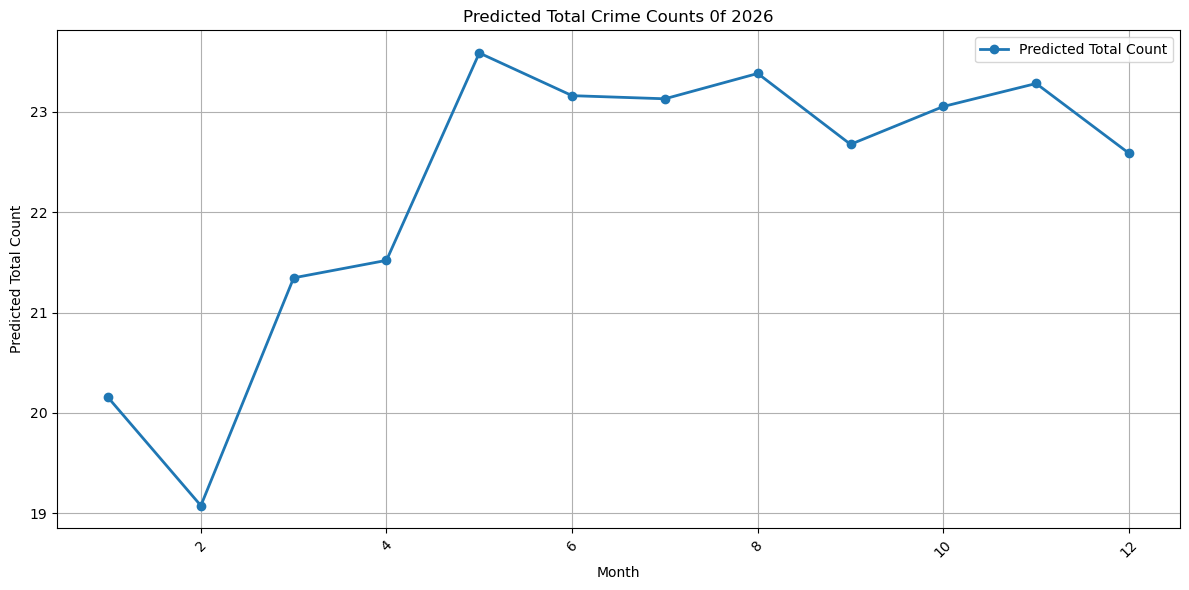

In [167]:
# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2026['OCC_MONTH'], 
         crime_2026['Predicted_Total_Count'], 
         linewidth=2, marker='o', label='Predicted Total Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Crime Counts 0f 2026')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

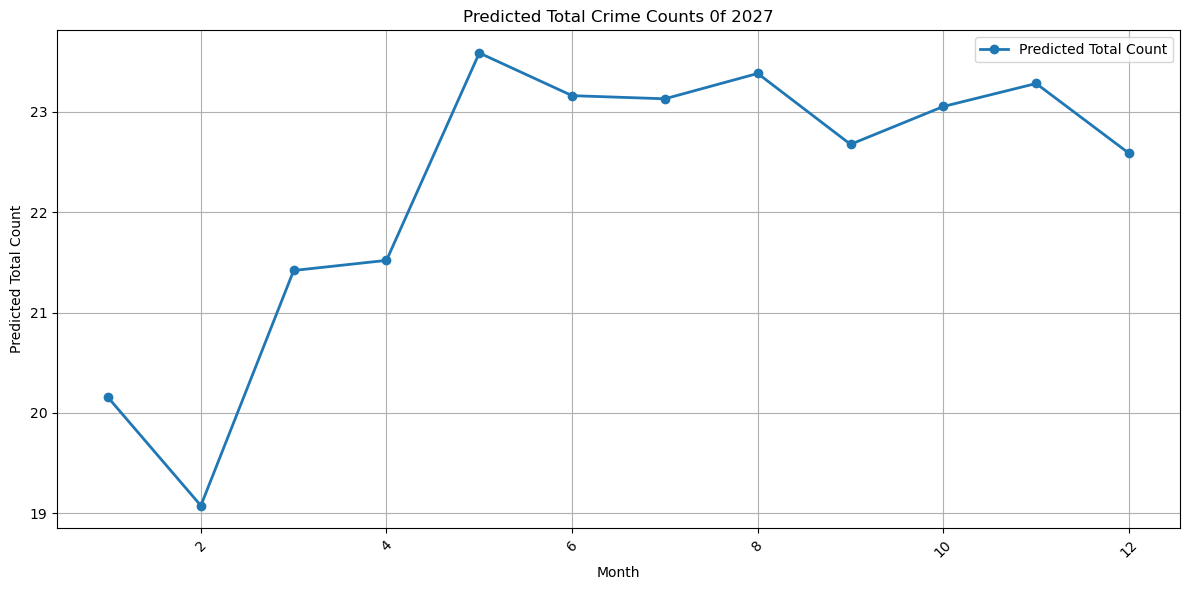

In [168]:
# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2027['OCC_MONTH'], 
         crime_2027['Predicted_Total_Count'], 
         linewidth=2, marker='o', label='Predicted Total Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Crime Counts 0f 2027')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Optimizing the models

In [29]:
# Create scorers for R-squared and MAE
r2_scorer = make_scorer(r2_score)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Minimize MAE

In [30]:
# Define the hyperparameter search space for Histogram-Based Gradient Boosting Regressor
param_dist_hist = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__l2_regularization': [0.0, 0.1, 0.2]
}

# Create the Histogram-Based Gradient Boosting Regressor and wrap it with MultiOutputRegressor
hgb_model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=1))

# Create RandomizedSearchCV object with multiple scoring metrics
random_search_hist = RandomizedSearchCV(
    estimator=hgb_model,
    param_distributions=param_dist_hist,
    n_iter=10,
    scoring={'r2': make_scorer(r2_score), 'mae': make_scorer(mean_absolute_error)},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1,
    return_train_score=True  # Optional: to get train scores for analysis
)

# Perform the hyperparameter search
random_search_hist.fit(X_train, y_train)

# Access results for both metrics
print(f"Best R-squared: {random_search_hist.best_score_}")  # Based on 'refit'
print(f"Best MAE: {-random_search_hist.cv_results_['mean_test_mae'][random_search_hist.best_index_]}")  # Negate MAE

# Get the best model
best_hgb_model = random_search_hist.best_estimator_

Best R-squared: -0.07234327285109235
Best MAE: -10.225096661187804


In [31]:
# Define the hyperparameter search space for Random Forest Regressor

param_dist_reg = {
    'n_estimators': [500, 700, 1000],          # Increase the number of trees
    'max_depth': [15, 20, 25, None],           # Allow deeper trees with finer steps
    'min_samples_split': [2, 3, 4, 5],         # Allow more splits
    'min_samples_leaf': [1, 2, 3],             # Smaller leaf sizes
    'max_features': [0.3, 0.5, 'sqrt', 'log2'],# Additional options for max features
    'bootstrap': [True, False]                 # Both bootstrap sampling options
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=25,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=10,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model (similar to HGB)
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")
best_rf_model = random_search_reg.best_estimator_

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 15, 'bootstrap': True}


In [32]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Mean Squared Error: 47.68928860759494
R-squared: 0.7797428888469431
mean absolute error: 5.133544303797469


In [33]:
# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor
y_h_pred = best_hgb_model.predict(X_test)

# Print the predicted crime counts for the test set for both models
print("Random Forest Predicted crime counts for (test set):", y_r_pred)
print("Histogram-Based Gradient Boosting Predicted crime counts for (test set):", y_h_pred)

Random Forest Predicted crime counts for (test set): [ 89.7851447   90.53937373  97.10392022  98.32249101 102.20677433
 104.26290792  30.11644933  28.23665902  31.22175509  30.86383004
  31.89936559  33.12235084  22.82485892  19.31231319  21.71380522
  20.36528606  19.3626661   18.40585764  21.24397321  17.595787
  20.47688004  19.16405699  18.0487566   16.50271725  18.86431075
  15.30774573  19.5172467   17.96426413  16.95937362  15.45582664
  18.29645586  15.51665375  20.75509488  19.07768274  19.58973716
  18.41136424  18.34240853  14.97459459  20.72023803  16.78915332
  17.5162697   18.30740618  15.60678824  10.8729244   13.70927332
  12.98339819  14.71009903  15.77118513  15.61648117  10.57026885
  12.23696751  12.99205057  15.72695738  16.93602231  15.78671674
  10.69289876  12.31412736  12.85177207  15.51992469  16.71022835
  16.07667157  10.98626067  12.81160651  11.92598238  14.71940807
  15.94273705  14.50449436  10.71510637  12.41839655  11.01375435
  13.50036738  13.3023406

In [34]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Mean Squared Error: 104.03843224157471
R-squared: 0.5194894869794124
mean absolute error: 7.748625408701621


In [35]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting.
h_mse = mean_squared_error(y_test, y_h_pred)
h_r2 = r2_score(y_test, y_h_pred)
h_mae = mean_absolute_error(y_test, y_h_pred)

print(f"Mean Squared Error: {h_mse}")
print(f"R-squared: {h_r2}")
print(f"mean absolute error: {h_mae}")

Mean Squared Error: 54.89960669312779
R-squared: 0.7464414100792103
mean absolute error: 5.745211113851994
